In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets.data_files import resolve_patterns_in_dataset_repository

Fitting the GLM, checking for outliers based on residuals, trying to fit once more

In [ ]:
# load and join fixation and participant data
compiled_fixations_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/compiled_fixations.csv'
participant_info_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/participant_info.csv'

compiled_fixations_df = pd.read_csv(compiled_fixations_url)
participant_info_df = pd.read_csv(participant_info_url)

merged_df = pd.merge(compiled_fixations_df, participant_info_df, on='ID')

# replace date of birth with age
merged_df['age'] = 2023 - merged_df['DoB']
merged_df = merged_df.drop('DoB', axis=1)

# drop irrelevant columns
fix_df = merged_df[['ID', 'age', 'Order', 'duration', 'Valid', 'Valid Freeviewing']]

# convert column names to lowercase
fix_df.columns = fix_df.columns.str.lower()

# leaving only valid viewers
valid_fix_df = fix_df[(fix_df['valid'] == True) & (fix_df['valid freeviewing'] == True)]

# dropping default year 2000 from dataset
valid_fix_df = valid_fix_df[(valid_fix_df['age'] != 23)]

Almost 40% of data is gone if we leave the default year 2000 out.

In [9]:
(fix_df.shape[0] - valid_fix_df.shape[0])/fix_df.shape[0]

0.37251602433193376

Fitting the GLM using Inverse Gaussian family of distribution and InversePower as link function

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4546
Model:                            GLM   Df Residuals:                     4543
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.28923
Method:                          IRLS   Log-Likelihood:                 7695.9
Date:                Fri, 01 Nov 2024   Deviance:                       978.91
Time:                        21:20:09   Pearson chi2:                 1.31e+03
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0005853
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7880      0.091     52.863      

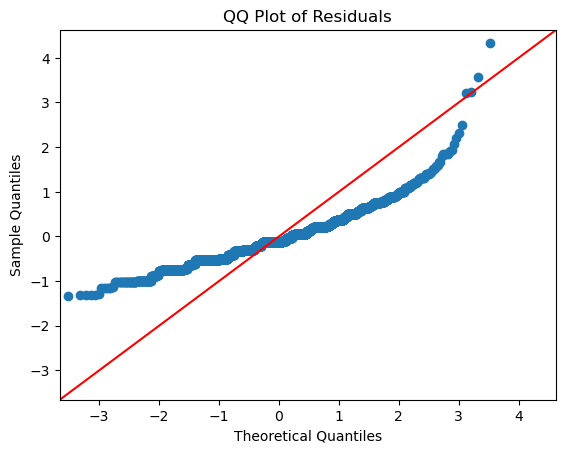

In [78]:
import statsmodels.formula.api as sm
import statsmodels.api as sma

grouped_df = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})
#grouped_df['duration'] = grouped_df['duration'] * 1000
#grouped_df['duration'] = np.log(grouped_df['duration'])
#grouped_df = grouped_df[grouped_df['age'] != 23]
#grouped_df = grouped_df[grouped_df['age'] < 66]
#grouped_df = grouped_df[grouped_df['age'] > 5]


# Fit a GLM with age and age_squared as covariates
model = sm.glm('duration ~ age + I(age**2)', data=grouped_df, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model.summary())

residuals = model.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()

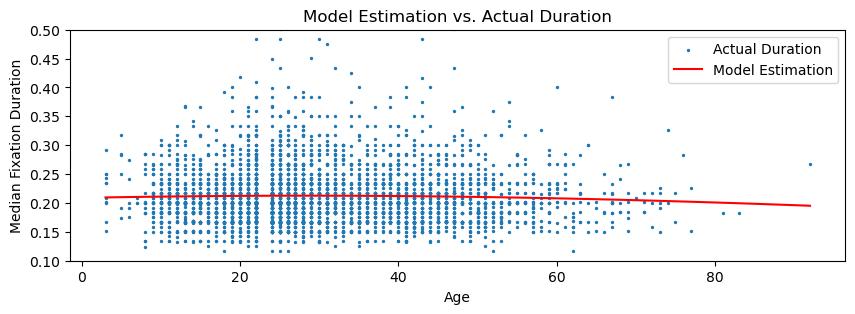

In [64]:
# Create a range of ages for plotting
age_range = np.linspace(grouped_df['age'].min(), grouped_df['age'].max(), 100)

# Predict durations for the age range using the fitted model
predicted_durations = model.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))

# Plot the actual durations and the model estimations
plt.figure(figsize=(10, 3))
plt.scatter(grouped_df['age'], grouped_df['duration'], label='Actual Duration', s=2)
plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
plt.ylim((0.1, 0.5))
plt.xlabel('Age')
plt.ylabel('Median Fixation Duration')
plt.title('Model Estimation vs. Actual Duration')
plt.legend()
plt.show()

## Removing the high_leverage points and fitting the model again

In [85]:
influence = model.get_influence()

# Calculate leverage (hat values)
leverage = influence.hat_matrix_diag

leverage_threshold = 2 * 3 / grouped_df.shape[0]  # 2 * num of covariates with intercept / number of experiments

In [68]:
grouped_df.shape[0]

4546

In [86]:
lo_leverage_points = leverage < leverage_threshold

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4190
Model:                            GLM   Df Residuals:                     4187
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.23262
Method:                          IRLS   Log-Likelihood:                 7350.9
Date:                Fri, 01 Nov 2024   Deviance:                       839.23
Time:                        21:26:37   Pearson chi2:                     974.
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01362
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.6999      0.130     43.762      

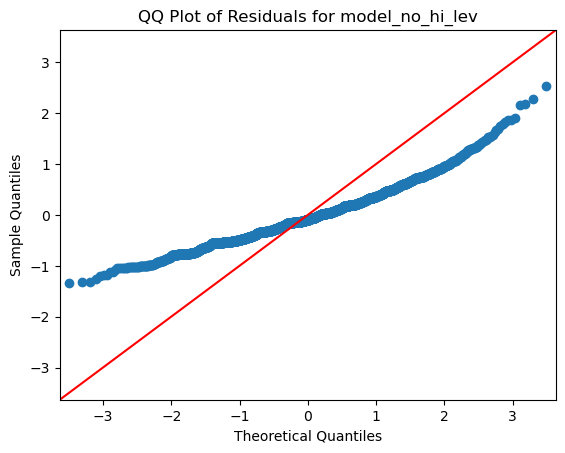

In [87]:
grouped_df_no_hi_lev = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})

grouped_df_no_hi_lev = grouped_df_no_hi_lev[lo_leverage_points]


# Fit a GLM with age and age_squared as covariates
model_no_hi_lev = sm.glm('duration ~ age + I(age**2)', data=grouped_df_no_hi_lev, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model_no_hi_lev.summary())

residuals = model_no_hi_lev.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals for model_no_hi_lev')
plt.show()

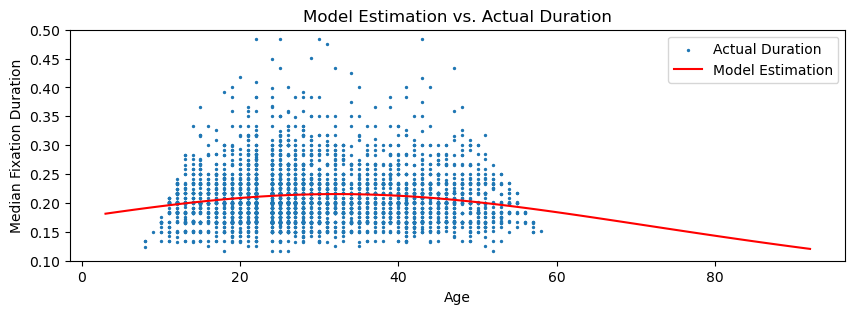

In [88]:
age_range = np.linspace(grouped_df['age'].min(), grouped_df['age'].max(), 100)
# Predict durations for the age range using the fitted model
predicted_durations = model_no_hi_lev.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))
# Plot the actual durations and the model estimations
plt.figure(figsize=(10, 3))
plt.scatter(grouped_df_no_hi_lev['age'], grouped_df_no_hi_lev['duration'], label='Actual Duration', s=2)
plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
plt.ylim((0.1, 0.5))
plt.xlabel('Age')
plt.ylabel('Median Fixation Duration')
plt.title('Model Estimation vs. Actual Duration')
plt.legend()
plt.show()

Removing high_leverage_points removes almost all dataset

## Pearson residuals

In [90]:
pearson_residuals = model.resid_pearson
# Define a threshold for outliers (e.g., ±2 or ±3)
threshold = 3  # Use ±2 or ±3 based on the desired strictness

# Identify outliers
non_outliers = np.abs(pearson_residuals) < threshold
non_outliers

id
20230314113311129    True
20230314115057038    True
20230314115611868    True
20230314120503166    True
20230314120855847    True
                     ... 
20231119170242080    True
20231121115804089    True
20231121121238463    True
20231121124149596    True
20231121131459835    True
Length: 4546, dtype: bool

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4538
Model:                            GLM   Df Residuals:                     4535
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.22528
Method:                          IRLS   Log-Likelihood:                 7944.9
Date:                Fri, 01 Nov 2024   Deviance:                       905.23
Time:                        21:33:42   Pearson chi2:                 1.02e+03
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0004246
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.8108      0.080     60.044      

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


AttributeError: module 'statsmodels.api' has no attribute 'figure'

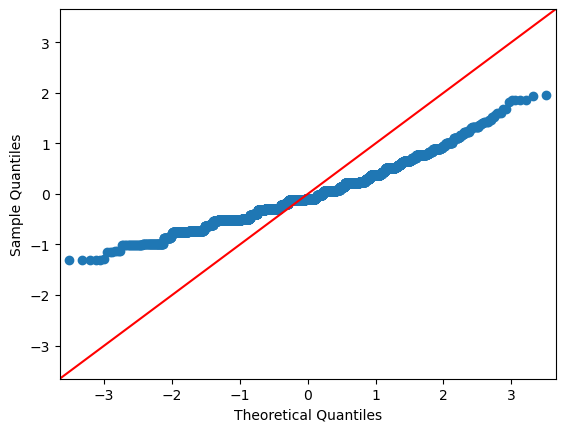

In [98]:
grouped_df_no_pearson_outliers = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})

grouped_df_no_pearson_outliers = grouped_df_no_pearson_outliers[non_outliers]


# Fit a GLM with age and age_squared as covariates
model_no_pearson_outliers = sm.glm('duration ~ age + I(age**2)', data=grouped_df_no_pearson_outliers, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model_no_pearson_outliers.summary())

residuals = model_no_pearson_outliers.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals for model_no_hi_lev')
plt.show()

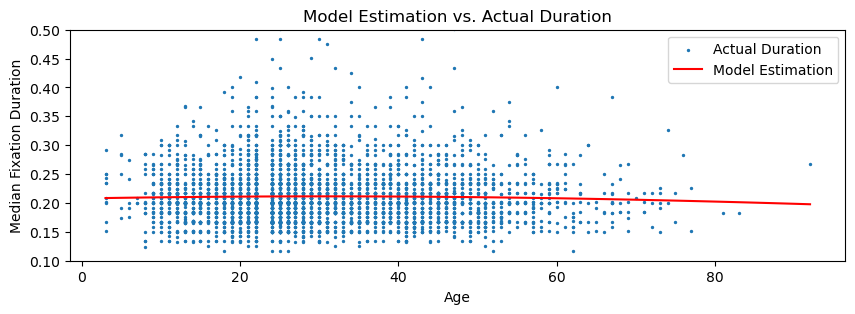

In [94]:
age_range = np.linspace(grouped_df['age'].min(), grouped_df['age'].max(), 100)
# Predict durations for the age range using the fitted model
predicted_durations = model_no_pearson_outliers.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))
# Plot the actual durations and the model estimations
plt.figure(figsize=(10, 3))
plt.scatter(grouped_df_no_pearson_outliers['age'], grouped_df_no_pearson_outliers['duration'], label='Actual Duration', s=2)
plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
plt.ylim((0.1, 0.5))
plt.xlabel('Age')
plt.ylabel('Median Fixation Duration')
plt.title('Model Estimation vs. Actual Duration')
plt.legend()
plt.show()